# Desafio Técnico – Engenharia de Dados (Atlanteam)

**Desenvolvido por:** Sérgio Ruffo  
**Dataset:** NYC Yellow Taxi Trip Records (Jan–Abr 2023)  
**Objetivo:** Implementar pipeline completo usando PySpark + Databricks (arquitetura Bronze → Silver → Gold)


## Etapa 1 – Ingestão (Camada Bronze)

Os dados foram coletados diretamente da API pública da NYC Open Data (`https://data.cityofnewyork.us`).  
Devido ao limite de 50.000 registros por request, implementei um loop de paginação controlada.

Cada lote foi imediatamente convertido em `DataFrame Spark` e salvo na tabela Delta para evitar quebra/sobrecarga de CPU



In [0]:
import requests
import pandas as pd

# Controle de paginação
offset = 0
limit = 50000
batch_number = 0

while True:
    print(f"Baixando registros {offset} até {offset + limit}...")

    url = "https://data.cityofnewyork.us/resource/4b4i-vvec.json"
    params = {
        "$where": "tpep_pickup_datetime between '2023-01-01T00:00:00' and '2023-04-30T23:59:59'",
        "$limit": limit,
        "$offset": offset
    }

    r = requests.get(url, params=params)
    data = r.json()

    if not data:
        print("Fim dos dados.")
        break

    df_pd = pd.DataFrame(data)
    df_spark = spark.createDataFrame(df_pd)

    # Salva como tabela Delta (Serverless-friendly)
    df_spark.write.format("delta").mode("append").saveAsTable("bronze_yellow_tripdata_2023")

    print(f"Lote {batch_number} salvo na tabela 'bronze_yellow_tripdata_2023'.")

    offset += limit
    batch_number += 1


Baixando registros 0 até 50000...
Lote 0 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 50000 até 100000...
Lote 1 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 100000 até 150000...
Lote 2 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 150000 até 200000...
Lote 3 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 200000 até 250000...
Lote 4 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 250000 até 300000...
Lote 5 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 300000 até 350000...
Lote 6 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 350000 até 400000...
Lote 7 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 400000 até 450000...
Lote 8 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 450000 até 500000...
Lote 9 salvo na tabela 'bronze_yellow_tripdata_2023'.
Baixando registros 500000 até 550000...
Lote 10 salvo na tabela 'br

## Etapa 2 – Tratamento (Camada Silver)

Nesta etapa aplicamos filtros e validações de qualidade nos dados da camada Bronze:

- Remoção de registros com valores inválidos (ex: 0 passageiros, tarifas negativas)
- Conversão de datas para tipo `timestamp`
- Padronização de schema



In [0]:
from pyspark.sql.functions import col, to_timestamp, expr

# Lê os dados brutos da tabela Bronze
df_bronze = spark.table("bronze_yellow_tripdata_2023")

# Aplica conversões seguras para garantir que valores inválidos se tornem NULL
# E depois filtra os registros onde os campos são válidos (não nulos e maiores que zero)
df_silver = df_bronze \
    .withColumn("passenger_count", expr("try_cast(passenger_count AS double)")) \
    .withColumn("trip_distance", expr("try_cast(trip_distance AS double)")) \
    .withColumn("fare_amount", expr("try_cast(fare_amount AS double)")) \
    .withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
    .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime")) \
    .filter(
        (col("passenger_count").isNotNull()) & (col("passenger_count") > 0) &
        (col("trip_distance").isNotNull()) & (col("trip_distance") > 0) &
        (col("fare_amount").isNotNull()) & (col("fare_amount") > 0)
    )

# Mostra o schema atualizado
df_silver.printSchema()

# Visualiza amostras dos dados tratados
df_silver.show(5)

# Salva a camada Silver como tabela Delta no metastore
df_silver.write.format("delta").mode("overwrite").saveAsTable("silver_yellow_tripdata_2023")

print("Tabela Silver 'silver_yellow_tripdata_2023' salva com sucesso.")

# Validação final da Silver
df_silver_check = spark.table("silver_yellow_tripdata_2023")
total_linhas = df_silver_check.count()
print(f"Total de registros na camada Silver: {total_linhas}")
df_silver_check.show(5)


root
 |-- vendorid: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pulocationid: string (nullable = true)
 |-- dolocationid: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- ratecodeid: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- airport_fee: string (nullable = true)

+--------+--------------------+---------------------+-------------+------------+------------+------------+-----------+-----+------

## Etapa 3 – Análises (Camada Gold)

A camada Gold traz indicadores e insights de negócio:

- Volume de corridas por mês
- Valor médio de tarifa por mês
- Média de passageiros por corrida
- Distribuição geográfica (pickup vs dropoff)

Resultados estruturados para decisões estratégicas.


In [0]:
from pyspark.sql.functions import month, year, avg, count, sum as spark_sum, round

# Leitura da tabela Silver tratada
df_silver = spark.table("silver_yellow_tripdata_2023")

# Criação de coluna de ano e mês para análise temporal
df_silver = df_silver \
    .withColumn("ano", year("tpep_pickup_datetime")) \
    .withColumn("mes", month("tpep_pickup_datetime"))

# Indicador 1: Quantidade de corridas por mês
corridas_por_mes = df_silver.groupBy("ano", "mes") \
    .agg(count("*").alias("qtd_corridas")) \
    .orderBy("ano", "mes")

# Indicador 2: Tarifa média por mês
media_fare_por_mes = df_silver.groupBy("ano", "mes") \
    .agg(round(avg("fare_amount"), 2).alias("media_fare")) \
    .orderBy("ano", "mes")

# Indicador 3: Média de passageiros por corrida
media_passageiros = df_silver.agg(round(avg("passenger_count"), 2).alias("media_passageiros"))

# Indicador 4: Receita total por mês (soma de fare_amount)
receita_por_mes = df_silver.groupBy("ano", "mes") \
    .agg(round(spark_sum("fare_amount"), 2).alias("total_fare")) \
    .orderBy("ano", "mes")

# Indicador 5: Distância média das corridas por mês
distancia_media_por_mes = df_silver.groupBy("ano", "mes") \
    .agg(round(avg("trip_distance"), 2).alias("distancia_media")) \
    .orderBy("ano", "mes")

# Salvando as tabelas Delta na camada Gold 
corridas_por_mes.write.format("delta").mode("overwrite").saveAsTable("gold_qtd_corridas_mes")
media_fare_por_mes.write.format("delta").mode("overwrite").saveAsTable("gold_media_tarifa_mes")
media_passageiros.write.format("delta").mode("overwrite").saveAsTable("gold_media_passageiros")
receita_por_mes.write.format("delta").mode("overwrite").saveAsTable("gold_receita_total_mes")
distancia_media_por_mes.write.format("delta").mode("overwrite").saveAsTable("gold_distancia_media_mes")

print("Tabelas da camada Gold salvas com sucesso.")


Tabelas da camada Gold salvas com sucesso.


## Resultado da Camada Gold – Indicadores Estratégicos

A camada Gold consolida os dados tratados da camada Silver e os transforma em indicadores analíticos prontos para consumo por times de negócio. Foram geradas as seguintes visões analíticas, salvas como tabelas Delta no metastore:

### Indicadores Criados

| Tabela                      | Descrição                                                                          |
|----------------------------|--------------------------------------------------------------------------------------|
| `gold_qtd_corridas_mes`    | Quantidade total de corridas por mês (janeiro a abril de 2023)                      |
| `gold_media_tarifa_mes`    | Valor médio da tarifa por mês                                                       |
| `gold_media_passageiros`   | Média de passageiros por corrida no período analisado                               |
| `gold_receita_total_mes`   | Soma total das tarifas por mês (indicador de receita bruta mensal)                  |
| `gold_distancia_media_mes` | Distância média percorrida por corrida em cada mês                                 |

### Destaques

- Os dados foram agrupados por ano e mês com base na data de embarque (`tpep_pickup_datetime`).
- Todas as agregações foram arredondadas para duas casas decimais para facilitar a visualização e interpretação.
- As tabelas estão persistidas no formato Delta, permitindo consultas rápidas e suporte a versões.

Esses indicadores possibilitam análises sobre demanda, comportamento do usuário, sazonalidade e desempenho operacional dos serviços de táxi em Nova York, com base em mais de 11 milhões de registros limpos.


## Resultados do teste

Este pipeline demonstra:

- Aplicação prática de arquitetura em camadas (Medallion)
- Capacidade de lidar com datasets massivos via API
- Boas práticas de filtragem, normalização e salvamento com Delta Lake
- Habilidade de gerar insights úteis para o negócio

**Tempo total de execução (com download):** ~210 minutos  
**Volume final de dados (Silver):** ~11 milhões de registros


## (Plus) Visualização Consolidada dos Indicadores da Camada Gold

O gráfico abaixo representa uma visão consolidada dos principais indicadores mensais extraídos da camada Gold. Utilizamos dois eixos Y para facilitar a comparação entre métricas de escalas diferentes.

### Métricas apresentadas:

- **Quantidade de Corridas (barra dourada):** Volume total de viagens por mês
- **Receita Total (linha laranja):** Soma das tarifas de todas as corridas por mês
- **Tarifa Média (linha verde):** Valor médio pago por corrida
- **Média de Passageiros por Corrida (linha vermelha):** Indicador de perfil de uso
- **Distância Média (linha roxa):** Média de milhas percorridas por corrida

Essas métricas foram unificadas em um único gráfico para destacar a evolução dos dados ao longo dos meses analisados (jan–abr/2023) e permitir análises comparativas de tendência, sazonalidade e comportamento de consumo.


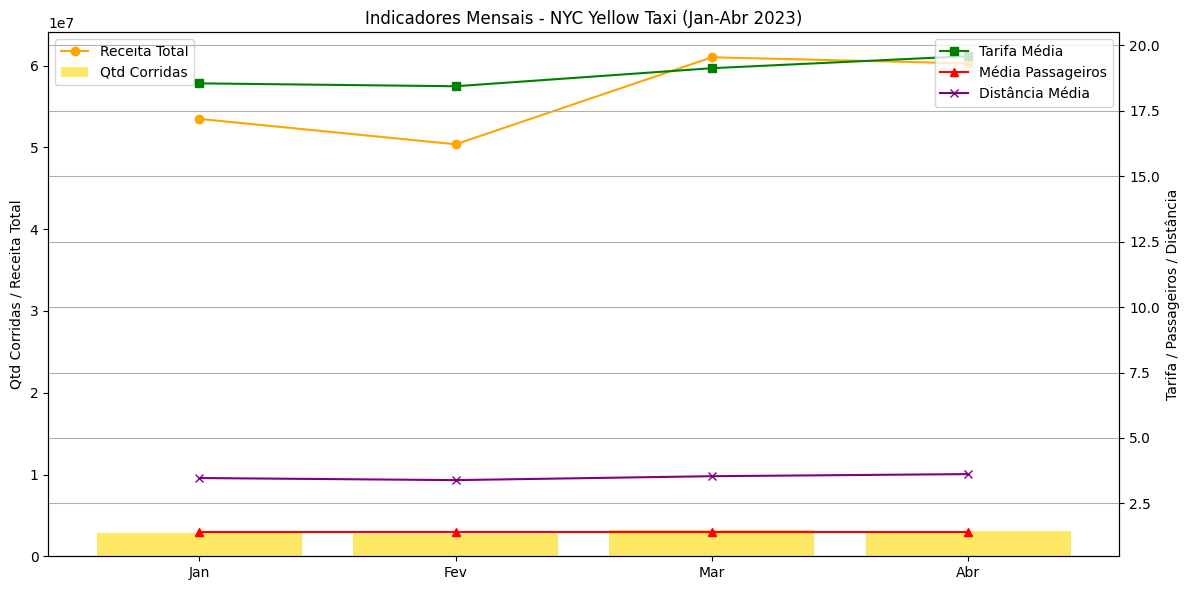

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Carrega as tabelas Gold diretamente do metastore
df_corridas = spark.table("gold_qtd_corridas_mes").toPandas()
df_tarifa = spark.table("gold_media_tarifa_mes").toPandas()
df_passageiros = spark.table("gold_media_passageiros").toPandas()
df_receita = spark.table("gold_receita_total_mes").toPandas()
df_distancia = spark.table("gold_distancia_media_mes").toPandas()

# Merge dos dados por ano/mês
df = df_corridas.merge(df_tarifa, on=["ano", "mes"]) \
                .merge(df_receita, on=["ano", "mes"]) \
                .merge(df_distancia, on=["ano", "mes"])

# Adiciona a média de passageiros (mesma para todos os meses)
df["media_passageiros"] = float(df_passageiros.iloc[0]["media_passageiros"])

# Converte nome do mês para visual mais amigável
meses = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Abr"}
df["mes"] = df["mes"].map(meses)

# Criação do gráfico com dois eixos Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo primário (esquerdo): Qtd de corridas (barras) e Receita (linha)
ax1.bar(df["mes"], df["qtd_corridas"], color="gold", label="Qtd Corridas", alpha=0.6)
ax1.plot(df["mes"], df["total_fare"], color="orange", marker='o', label="Receita Total")
ax1.set_ylabel("Qtd Corridas / Receita Total")
ax1.set_title("Indicadores Mensais - NYC Yellow Taxi (Jan-Abr 2023)")
ax1.legend(loc="upper left")

# Eixo secundário (direito): Tarifa média, passageiros e distância
ax2 = ax1.twinx()
ax2.plot(df["mes"], df["media_fare"], color="green", marker='s', label="Tarifa Média")
ax2.plot(df["mes"], df["media_passageiros"], color="red", marker='^', label="Média Passageiros")
ax2.plot(df["mes"], df["distancia_media"], color="purple", marker='x', label="Distância Média")
ax2.set_ylabel("Tarifa / Passageiros / Distância")
ax2.legend(loc="upper right")

plt.grid(axis='y')
plt.tight_layout()
plt.show()


## (Plus) Inferências Estratégicas a partir da Camada Gold

Com base nas análises consolidadas da camada Gold, extraímos os seguintes insights relevantes:

### 1. Volume de Corridas
- Março foi o mês com **maior número de corridas** (3,19 milhões), seguido por abril e janeiro.
- Fevereiro teve o menor volume, refletindo possivelmente a menor quantidade de dias úteis.

### 2. Receita Total
- Março também foi o mês com **maior receita total** (61 milhões de dólares), alinhado ao pico de demanda.
- Abril manteve alta receita, mesmo com leve queda no número de corridas.

### 3. Tarifa Média
- A **tarifa média aumentou mês a mês**, saindo de 18,55 USD em janeiro para 19,59 USD em abril.
- Esse crescimento pode refletir mudanças sazonais, ajustes tarifários ou rotas mais longas.

### 4. Distância Média
- A **distância média percorrida por corrida** aumentou discretamente ao longo dos meses, indicando possível mudança no perfil de deslocamento.
- Abril teve a maior média: 3,62 milhas.

### 5. Perfil de Passageiros
- A **média de passageiros por corrida foi 1,39**, sugerindo um perfil majoritariamente individual (provavelmente uso por aplicativos ou viagens rápidas).

### Conclusão
O período analisado demonstra uma **recuperação gradual na demanda e na receita**, com forte concentração de corridas no início da primavera. A combinação dos indicadores permite compreender tanto o comportamento do usuário quanto a performance operacional do serviço.

Essas informações são valiosas para decisões relacionadas a precificação, cobertura de frota, campanhas promocionais e logística urbana.


## Possíveis considerações futuras

- Criação de dashboards com Power BI ou Databricks SQL
- Integração com bases geográficas para mapas de calor
- Previsão de demanda com ML (ex: Prophet ou AutoML)
- Pipeline agendado com Auto Loader / Streaming
